In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [3]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [4]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
#     y_fit = function(x_values, *fitparams)
    
    return fitparams #, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [6]:
qb = 0 # qubit to operate on

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=qb)

describe_qubit(qb, props)

Qubit 0 has a 
  - T1 time of 61.40931280600872 microseconds
  - T2 time of 84.00901875550208 microseconds
  - U2 gate error of 0.0005413173807719701
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.664858082685952 GHz


In [43]:
shots = 1024 # determines clarity of results

period = 100 # Rabi oscillation period
cycles = [5] # number of rabi cycles to perform for each oscillation
datapoints_per_period = 50 # density of datapoints in a cycle capture
cycles_to_plot = 3 # cycles to capture oscillation with, integer

scale_factor = 1e-14
predict_const = 54.07447683508908
predict_power =  -0.9924372112785861

sig_predict_const = 11.48089749887833 
sig_predict_power = -0.9672752940591574

In [45]:
# begin with no pulses in the experiment
experiments = []

data_times = []
drive_amp = np.power(period/predict_const,1/predict_power)

# make array of constant pulses that we can use to make all drive lengths
constant_pulse_lengths = [2**i for i in range(17)] # largest i that you can fit in 250,000 pulse samples
constant_pulses = []
for i in constant_pulse_lengths: 
    constant_pulses.append(pulse_lib.Constant(duration=i, amp=drive_amp))
leftover_constant_pulses = []
leftover_constant_pulses_lengths = [i for i in range(65, 128)]
for i in range(65, 128): # hacky way of getting the leftover pulses. Can't make a pulse smaller than 64
    leftover_constant_pulses.append(pulse_lib.Constant(duration=i, amp=drive_amp))

s = lambda amp: sig_predict_const * np.power(amp, sig_predict_power)
drive_sigma = get_closest_multiple_of_16(int(s(drive_amp)))

for cycle in cycles:
    drive_duration = period*cycle    
    center_meas = get_closest_multiple_of_16(cycle*period)
    datapoints_per_period = 6
    data_separation = period // datapoints_per_period
    print(data_separation)

    drive_times = range(center_meas - get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        center_meas + get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        16)
    for i in range(len(drive_times)):  
        normal_gauss_square = pulse_lib.GaussianSquare(duration=drive_times[i], amp=drive_amp,
                            sigma=drive_sigma, width=drive_times[i]-(6*drive_sigma)).get_sample_pulse()
        front_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[:3*drive_sigma], 'front_cap')
        end_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[-3*drive_sigma:], 'end_cap')

        this_schedule = pulse.Schedule(name=f"Rabi duration = {i}")
        adjusted_time = drive_times[i] - (6 * drive_sigma)

        # add front cap
        this_schedule += Play(front_cap, drive_chan)
        
        extra_time = adjusted_time
        if (adjusted_time > sum(constant_pulse_lengths)):
            while (extra_time > sum(constant_pulse_lengths)):
                this_schedule += Play(constant_pulses[-1], drive_chan)
                extra_time -= constant_pulse_lengths[-1]
            bin_time = '{0:b}'.format(extra_time)
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i > 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
        else:
            bin_time = '{0:b}'.format(adjusted_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i > 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
        print(adjusted_time, bin_time, extra_time)

        # add end cap
        this_schedule += Play(end_cap, drive_chan)
#         long_pulse = np.concatenate(consts, axis=0)
#         this_schedule += Play(SamplePulse(long_pulse, name="long pulse"), drive_chan)

        this_schedule += measure << this_schedule.duration
        experiments.append(this_schedule)

    data_times.append(drive_times)

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
experiments.append(schedule) # add zero state to experiments
schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qb).samples), drive_chan)
schedule += measure << schedule.duration
experiments.append(schedule) # add 1 state to experiments

16
256 000000001 0
272 000010001 16
288 000001001 32
304 000011001 48
320 000000101 64
336 000010101 80
352 000001101 96
368 000011101 112
384 000000011 0
400 000010011 16
416 000001011 32
432 000011011 48
448 000000111 64
464 000010111 80
480 000001111 96
496 000011111 112
512 0000000001 0
528 0000100001 16


In [46]:
sum(leftover_constant_pulses_lengths)

6048

In [ ]:
leftover_constant_pulses[]

In [29]:
num_shots_per_point = 1024
program = assemble(experiments,
                   backend=backend,
                   meas_level=1,
                   meas_return='avg',
                   shots=num_shots_per_point)
job = backend.run(program)

In [38]:
results = job.result(timeout=120)
all_results = []
for i in range(len(experiments)):
    all_results.append(np.angle(results.get_memory(i)[qb] * scale_factor, deg=True))

In [39]:
qb_rabi_data = []
all_params = []
all_fits = []
num_experiments = sum([len(x) for x in data_times])

state0 = all_results[len(all_results)-2]
state1 = all_results[len(all_results)-1]

past_exp = 0
for i in range(len(cycles)):
    single_period_data = []
    for j in range(len(data_times[i])):
        # Get the results for `qubit` from the ith experiment
        single_period_data.append(all_results[past_exp+j])

    qb_rabi_data.append(single_period_data)
    past_exp += len(data_times[i])
    
    fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)
    p = fit_function(list(data_times[i]), qb_rabi_data[i], fun, 
                     [np.max(qb_rabi_data[i]) - np.min(qb_rabi_data[i]), 0, period, 0])
    all_params.append(p)
    
    y_fit = [fun(x, p[0], p[1], p[2], p[3]) for x in list(data_times[i])]
    all_fits.append(y_fit)

Period: 142.20790824788563 dt


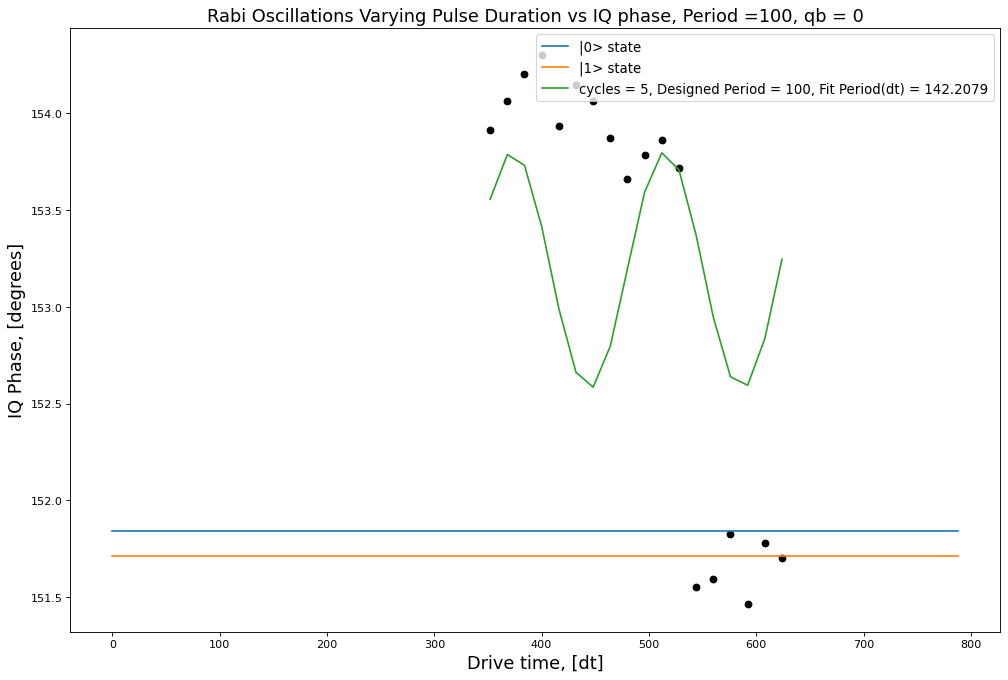

In [40]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

end_plot_time = (period*cycles[-1])+(len(data_times[-1])*16)
plt.plot([0, end_plot_time],2*[state0],label="|0> state")
plt.plot([0, end_plot_time],2*[state1],label="|1> state")

for i in range(len(cycles)):
    plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
    plt.plot(data_times[i], all_fits[i],
    label="cycles = " + str(cycles[i]) + ", Designed Period = " + str(period) + ", Fit Period(dt) = " + str(np.around(all_params[i][2],decimals=4)))
print(f'Period: {p[2]} dt')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('IQ Phase, [degrees]', fontsize=16)
plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase, Period =" + str(period) + ", qb = " + str(qb), fontsize=16)
plt.show()

In [ ]:
for i in range(len(cycles)):
    print(f'{np.max(qb_rabi_data[i])-np.min(qb_rabi_data[i])}')

In [ ]:
amps = abs(np.array(all_params)[:,0])

xval = [1,2,3,4,5]
fit = lambda t,A,T,C: A * np.exp(-t/T) + C
p = fit_function(xval, amps, fit, [3, -1, -1])
y_fit = [fit(x, p[0], p[1], p[2]) for x in [1,2,3,4,5]]

plt.scatter(amps, xval)
# plt.plot(xval, y_fit)
print(p)

In [ ]:
i = 3
plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
plt.plot(data_times[i], all_fits[i])

In [ ]:
print(amps)

In [ ]:
print(abs(np.array(all_params)[:,0]))

In [ ]:
plt.scatter(np.multiply(cycles,period),abs(np.array(all_params)[:,0]),label="Amplitudes")